<a href="https://colab.research.google.com/github/Meyssemmedini/PRODIGY_DS_03/blob/main/Fire_alarmclassification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#classification problem

#Preliminary Steps

##Data mounting

In [ ]:
#data mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##import packages

In [ ]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import modeling tools
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay



In [ ]:
# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')
#
import warnings
warnings.filterwarnings("ignore")

##functions

In [ ]:
def plot_numeric(df,col):
  """EDA function to plot a histogram and boxplot for the selected column"""
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  sns.histplot(data=df,x = col,ax = axes[0])
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--',
           label=f"Mean Value = {mean_value:,.2f}",);

  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--',
           label=f"Median Value = {med_value:,.2f}");

  axes[0].legend();

  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph
  axes[0].set_title(f'EDA for {col}')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()

In [ ]:

def print_evaluation_metrics(model_name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    # Calculate metrics for the training set
    train_score = accuracy_score(y_true_train, y_pred_train)
    train_rec = recall_score(y_true_train, y_pred_train)
    train_prec = precision_score(y_true_train, y_pred_train)

    # Calculate metrics for the test set
    test_score = accuracy_score(y_true_test, y_pred_test)
    test_rec = recall_score(y_true_test, y_pred_test)
    test_prec = precision_score(y_true_test, y_pred_test)

    # Print the model information
    print(f'{model_name} Evaluation Metrics:')

    # Print training set metrics
    print('\nTraining set Evals:')
    print(f'Accuracy: {train_score:.3f}')
    print(f'Recall: {train_rec:.3f}')
    print(f'Precision: {train_prec:.3f}')

    # Print a separator
    print('\n' + '='*30 + '\n')

    # Print test set metrics
    print('Test set Evals:')
    print(f'Accuracy: {test_score:.3f}')
    print(f'Recall: {test_rec:.3f}')
    print(f'Precision: {test_prec:.3f}')




##data loading

In [ ]:
#read data
df = pd.read_csv ("https://docs.google.com/spreadsheets/d/e/2PACX-1vTAQMDlyQdVuWy9le6OcM14fIZdQKg0s_PXhWUYIjUoB_rFpOz9Sv0K05ryiIQkTezghYtkLj6maFCW/pub?gid=2097390352&single=true&output=csv")
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62633 entries, 0 to 62632
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      62633 non-null  int64  
 1   Unnamed: 1      62633 non-null  int64  
 2   UTC             62633 non-null  int64  
 3   Temperature[C]  43843 non-null  float64
 4   Humidity[%]     51985 non-null  float64
 5   eCO2[ppm]       62633 non-null  int64  
 6   Raw H2          47602 non-null  float64
 7   Raw Ethanol     62633 non-null  object 
 8   Pressure[hPa]   62633 non-null  object 
 9   PM1.0           62633 non-null  float64
 10  PM2.5           62633 non-null  float64
 11  NC0.5           62633 non-null  float64
 12  NC1.0           62633 non-null  float64
 13  NC2.5           62633 non-null  float64
 14  CNT             62633 non-null  int64  
 15  Fire Alarm      62633 non-null  int64  
dtypes: float64(8), int64(6), object(2)
memory usage: 7.6+ MB


,Unnamed: 0,Unnamed: 1,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,0,1655127852,19.117,56.52,400,13314.0,High,med,1.71,1.78,11.77,1.835,0.041,1928,0
1,1,1,1654777894,NaN,55.78,400,12889.0,Low,High,1.71,1.78,11.79,1.838,0.042,22541,1
2,2,2,1654785729,26.160,51.93,406,12989.0,Low,High,1.95,2.03,13.43,2.095,0.047,20717,1
3,3,3,1654773681,26.960,52.51,577,NaN,Low,High,2.31,2.40,15.91,2.481,0.056,22852,1
4,4,4,1654779348,19.860,NaN,400,12910.0,Low,High,1.72,1.79,11.85,1.848,0.042,14193,1


In [ ]:
#the dimensions of the Data
df.shape

(62633, 16)

**Dictionary**

- UTC:
  - The timestamp or time at which the readings were recorded.
- Temperature[C]:
  - The temperature in degrees Celsius.
- Humidity[%]:
  - The percentage of humidity in the air.
- eCO2[ppm]:
  - The concentration of carbon dioxide in parts per million.
- Raw H2:
  - Measurement related to the levels of raw hydrogen.
- Raw Ethanol:
  - Measurement related to the levels of raw ethanol.
- Pressure[hPa]:
  - Atmospheric pressure in hectopascals.
- PM1.0, PM2.5:
  - Concentrations of particulate matter with sizes 1.0 and 2.5 micrometers.
- NC0.5, NC1.0, NC2.5:
  - Number concentrations of particles of different sizes (0.5, 1.0, 2.5 micrometers).
- CNT:
  - A count related to particles.
- Fire Alarm:
  - Indicates whether a fire alarm is triggered or not (binary status).

#Prepare the data for exploratory analysis purposes

##Data cleaning

In [ ]:
#drpping uncessary columns
df.drop(columns=['Unnamed: 0', 'Unnamed: 1'], inplace=True)

In [ ]:
#Count the number of duplicate rows in a DataFrame.
df.duplicated().sum()
if df.duplicated().sum() == 0:
  print("there is no duplicated rows in our dataframe")

there is no duplicated rows in our dataframe


###checking for inconsistencies

In [ ]:
#checking Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62633 entries, 0 to 62632
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62633 non-null  int64  
 1   Temperature[C]  43843 non-null  float64
 2   Humidity[%]     51985 non-null  float64
 3   eCO2[ppm]       62633 non-null  int64  
 4   Raw H2          47602 non-null  float64
 5   Raw Ethanol     62633 non-null  object 
 6   Pressure[hPa]   62633 non-null  object 
 7   PM1.0           62633 non-null  float64
 8   PM2.5           62633 non-null  float64
 9   NC0.5           62633 non-null  float64
 10  NC1.0           62633 non-null  float64
 11  NC2.5           62633 non-null  float64
 12  CNT             62633 non-null  int64  
 13  Fire Alarm      62633 non-null  int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 6.7+ MB


In [ ]:
for column in df.select_dtypes(include='object').columns:
    print(f'Value counts for {column}:')
    print(df[column].value_counts())
    print('\n')

Value counts for Raw Ethanol:
Low         27581
Medium      13276
low          7441
High         6986
medium       3622
high         1893
Very Low     1427
very low      407
Name: Raw Ethanol, dtype: int64


Value counts for Pressure[hPa]:
High    39303
high    10688
Med      9026
med      2462
Low       899
low       255
Name: Pressure[hPa], dtype: int64




In [ ]:
df['Raw Ethanol'] = df['Raw Ethanol'].replace({'low': 'Low',
                                               'medium': 'Medium',
                                               'high':'High',
                                               'very low': 'Very Low'})
df['Pressure[hPa]'] = df['Pressure[hPa]'].replace({'low': 'Low',
                                               'med': 'Medium',
                                               'high':'High',
                                               'Med': 'Medium'})


In [ ]:
#checking impossible values in numeric columns
df.describe()

,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
count,6.263300e+04,43843.000000,51985.000000,62633.000000,47602.000000,62633.000000,62633.000000,62633.000000,62633.000000,62633.000000,62633.000000,62633.000000
mean,1.654792e+09,15.952252,48.462203,670.008398,12943.810491,100.589507,184.458999,491.440068,203.576810,80.045255,10510.883943,0.714591
std,1.100006e+05,14.361454,9.368010,1905.840671,270.421548,922.502411,1976.258689,4265.560446,2214.685955,1083.357380,7598.035549,0.451612
min,1.654712e+09,-22.010000,-60.980000,400.000000,10668.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.654743e+09,10.932000,47.530000,400.000000,12831.000000,1.280000,1.340000,8.820000,1.384000,0.033000,3625.000000,0.000000
50%,1.654762e+09,20.124000,50.160000,400.000000,12924.000000,1.810000,1.880000,12.450000,1.943000,0.044000,9335.000000,1.000000
75%,1.654778e+09,25.415000,53.240000,438.000000,13109.000000,2.090000,2.180000,14.420000,2.249000,0.051000,17164.000000,1.000000
max,1.655130e+09,59.930000,75.200000,60000.000000,13803.000000,14333.690000,45432.260000,61482.030000,51914.680000,30026.438000,24993.000000,1.000000


Humidity cannot be negative

In [ ]:
# Make the humidity values positive
df['Humidity[%]'] = df['Humidity[%]'].abs()
df['Humidity[%]'].describe()

count    51985.000000
mean        48.559106
std          8.851991
min         10.740000
25%         47.540000
50%         50.160000
75%         53.250000
max         75.200000
Name: Humidity[%], dtype: float64

In [ ]:
#checking Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62633 entries, 0 to 62632
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62633 non-null  int64  
 1   Temperature[C]  43843 non-null  float64
 2   Humidity[%]     51985 non-null  float64
 3   eCO2[ppm]       62633 non-null  int64  
 4   Raw H2          47602 non-null  float64
 5   Raw Ethanol     62633 non-null  object 
 6   Pressure[hPa]   62633 non-null  object 
 7   PM1.0           62633 non-null  float64
 8   PM2.5           62633 non-null  float64
 9   NC0.5           62633 non-null  float64
 10  NC1.0           62633 non-null  float64
 11  NC2.5           62633 non-null  float64
 12  CNT             62633 non-null  int64  
 13  Fire Alarm      62633 non-null  int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 6.7+ MB


data types make sense according to the dict

###dealing with missing values

In [ ]:
#identifiying the missing data
df.isna().sum()[df.isna().sum() > 0]

Temperature[C]    18790
Humidity[%]       10648
Raw H2            15031
dtype: int64

In [ ]:
#checking the % of missing val in each feature
(df.isna().sum() / len(df) * 100)[df.isna().sum() > 0]

Temperature[C]    30.000160
Humidity[%]       17.000623
Raw H2            23.998531
dtype: float64

###imputing missing data



####1. for Temperature[C]

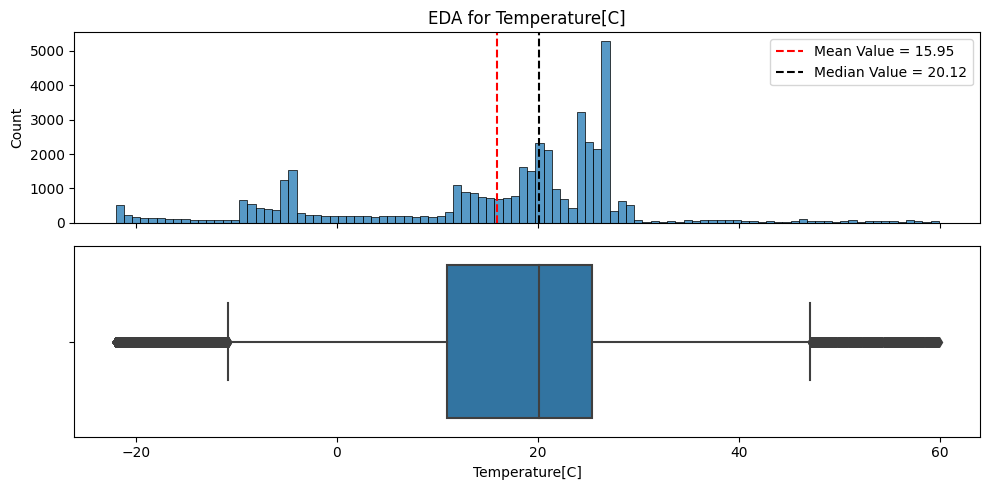

In [ ]:
plot_numeric(df,"Temperature[C]")


The 'Temperature[C]' exhibits a moderate negative skewness and the potential presence of outliers.

- **Imputation Method: Median Imputation**


- **Justification:**

  - Robustness to Skewed Distributions: Median imputation is inherently robust to skewed distributions, aligning well with the observed negative skewness in the temperature data.

  - Handling Outliers: While acknowledging the potential impact of outliers, especially considering the moderate negative skewness, a simplified solution is preferred. Therefore, median imputation is chosen over more complex outlier-handling techniques, such as the interquartile range (IQR) method.

  - Simplicity: The choice of median imputation balances robustness and simplicity, providing an effective and straightforward solution for handling missing values.

In [ ]:
df['Temperature[C]'].fillna(df['Temperature[C]'].median(), inplace = True)
df['Temperature[C]'].isna().sum()

0

####2. Humidity [%]

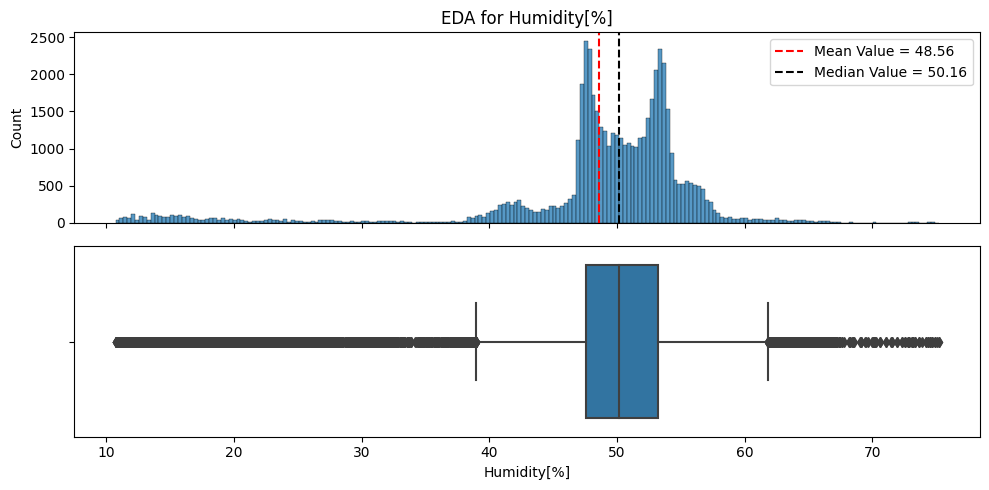

In [ ]:
plot_numeric(df,"Humidity[%]")


The 'Humidity[%]' distribution is observed to be symmetric and bimodal.

**Imputation Method: Mean Imputation**
- Justification:

  - Symmetry and Bimodality: The distribution's symmetry, along with its bimodal nature, indicates a balanced spread of values around the central tendency. In such cases, mean imputation is a suitable choice to provide a representative estimate for the missing values.

  - Robustness to Symmetric Distributions: Mean imputation is inherently robust to symmetric distributions, as it leverages the central tendency without being significantly influenced by outliers or skewed tails.

 - Handling Outliers: While acknowledging the presence of potential outliers, the decision is made to opt for mean imputation for simplicity reasons. This choice avoids the complexity associated with more advanced outlier-handling techniques, providing a straightforward and effective solution.

In [ ]:
df['Humidity[%]'].fillna(df['Humidity[%]'].mean(), inplace = True)
df['Humidity[%]'].isna().sum()

0

####3. for RAW H2

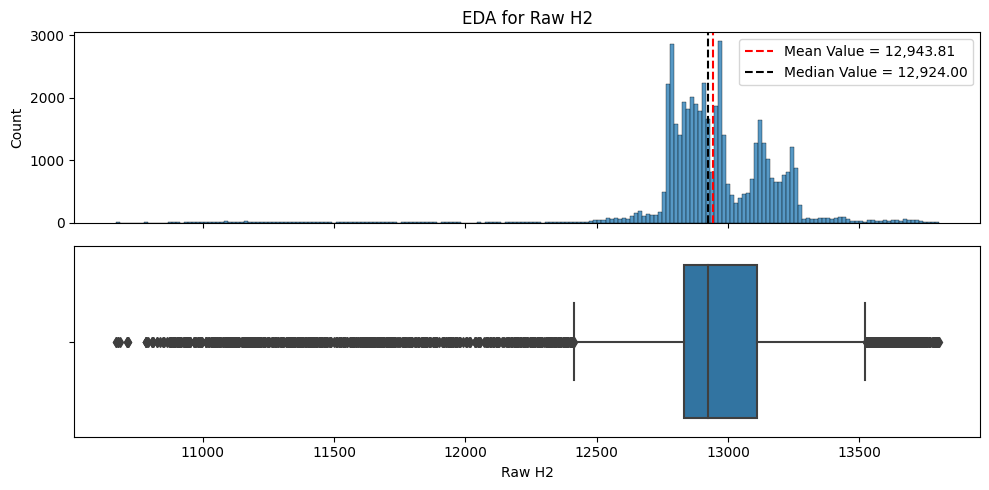

In [ ]:
plot_numeric(df,"Raw H2")

"The 'Raw H2' distribution exhibits a positive skewness and potential outliers.

**Imputation Method: Median Imputation**
- Justification:

  - positive Skewness: The positive skewness observed in the 'Raw H2' distribution suggests an asymmetric spread of values, making median imputation a suitable choice. Median imputation is robust to skewed distributions and less influenced by extreme values.

  - Handling Outliers: Acknowledging the potential presence of outliers, the decision is made to opt for median imputation. This choice prioritizes simplicity over more intricate outlier-handling methods, providing an effective solution for addressing missing values.

  - Robustness: Median imputation ensures robustness to the negative skewness and potential outliers, offering a stable estimate of central tendency in the presence of skewed data.

In [ ]:
df['Raw H2'].fillna(df['Raw H2'].median(), inplace = True)
df['Raw H2'].isna().sum()

0

## data visualization & Analysis

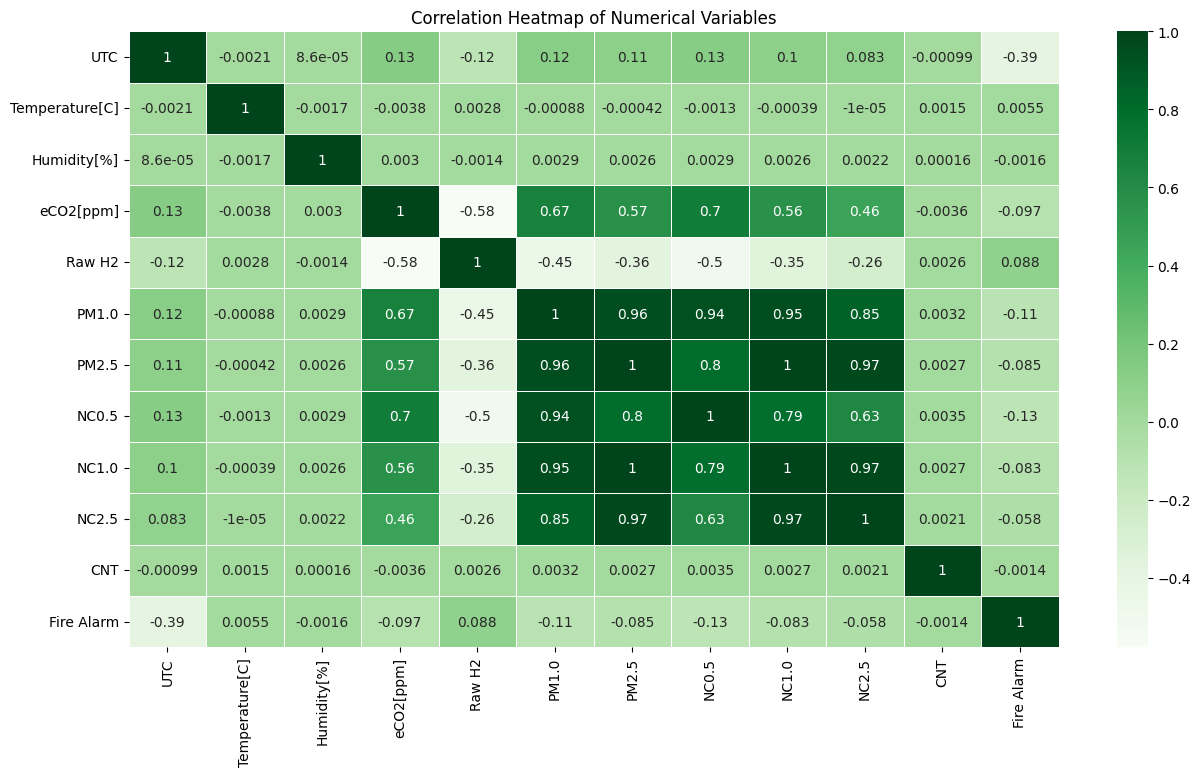

In [ ]:
numerical_columns = df.select_dtypes(include=['number']).columns
corr_matrix = df[numerical_columns].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Greens', linewidths=.5)
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


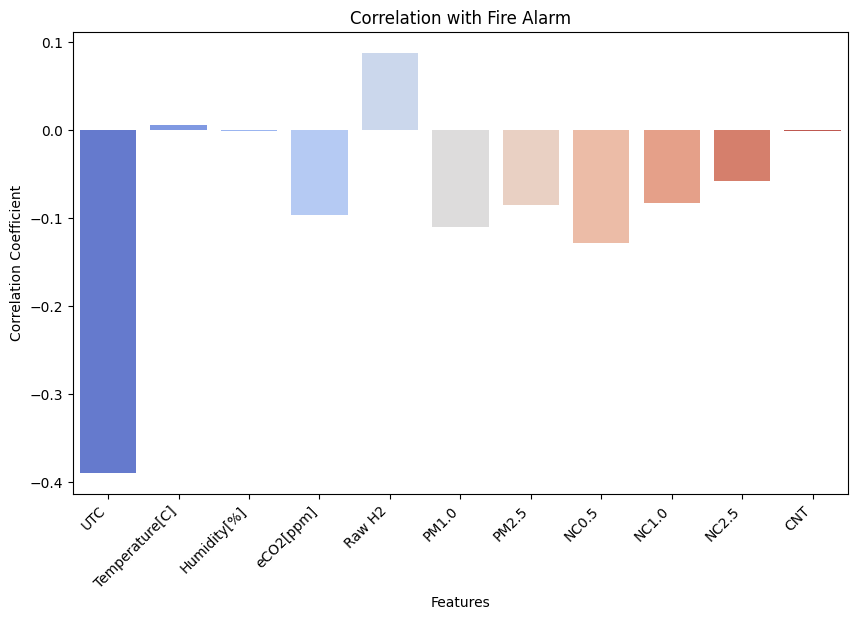

In [ ]:
# Calculate correlation coefficients
correlation_with_fire_alarm = df[numerical_columns].corr()['Fire Alarm'].drop('Fire Alarm')

# Bar Plot: Correlation with Fire Alarm
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_fire_alarm.index, y=correlation_with_fire_alarm.values, palette='coolwarm')
plt.title('Correlation with Fire Alarm')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
df.columns

Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2',
       'Raw Ethanol', 'Pressure[hPa]', 'PM1.0', 'PM2.5', 'NC0.5', 'NC1.0',
       'NC2.5', 'CNT', 'Fire Alarm'],
      dtype='object')

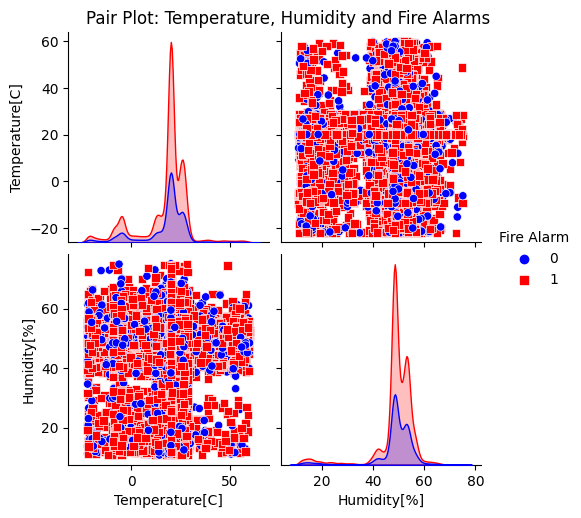

In [ ]:
# Pair Plot: Temperature, Humidity and Fire Alarms
sns.pairplot(df[['Temperature[C]', 'Humidity[%]', 'Fire Alarm']], hue='Fire Alarm', markers=["o", "s"], palette={0: 'blue', 1: 'red'})
plt.suptitle('Pair Plot: Temperature, Humidity and Fire Alarms', y=1.02)
plt.show()


The plot shows that there is a positive correlation between temperature and fire alarms. This means that as temperature increases, the likelihood of a fire alarm going off also increases. There is also a positive correlation between humidity and fire alarms. However, this correlation is weaker than the correlation between temperature and fire alarms. This means that humidity is a less significant factor in predicting fire alarms than temperature.

Overall, temperature and humidity are both factors that can contribute to fire alarms. However, temperature is the more significant factor.

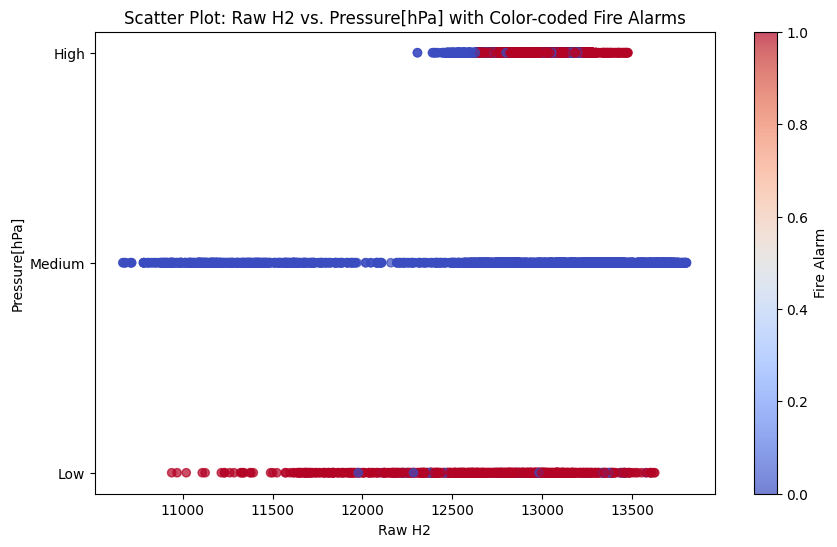

In [ ]:
# Scatter Plot: Raw H2 vs. Pressure[hPa] with Color-coded Fire Alarms
plt.figure(figsize=(10, 6))
plt.scatter(df['Raw H2'], df.sort_values('Pressure[hPa]')['Pressure[hPa]'], c=df['Fire Alarm'], cmap='coolwarm', alpha=0.7)
plt.title('Scatter Plot: Raw H2 vs. Pressure[hPa] with Color-coded Fire Alarms')
plt.xlabel('Raw H2')
plt.ylabel('Pressure[hPa]')
plt.colorbar(label='Fire Alarm')
plt.show()



this scatter plot shows the relationship between the amount of hydrogen gas (Raw H2) and the air pressure (Pressure[hPa]) in a certain environment. with color-coded circles representing the number of fire alarms that were triggered at different combinations of Raw H2 and Pressure[hPa].

The plot indicates a possible relationship between Raw H2, Pressure[hPa], and the occurrence of fire alarms. It appears that there is a higher frequency of fire alarms triggered when the Raw H2 levels are higher, especially at lower Pressure[hPa] values.

The overall trend of the plot suggests that there is a positive correlation between Raw H2 and Pressure[hPa], meaning that as the amount of hydrogen gas increases, the air pressure also tends to increase. However, there seems to be a degree of variability in this relationship.



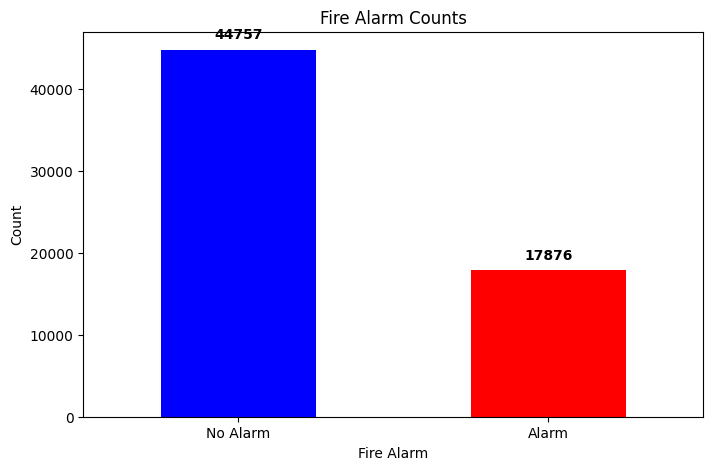

In [ ]:
# Bar Plot: Fire Alarm Counts
plt.figure(figsize=(8, 5))
counts = df['Fire Alarm'].value_counts()
ax = counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Fire Alarm Counts')
plt.xlabel('Fire Alarm')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Alarm', 'Alarm'], rotation=0)

# Add annotations
for i, count in enumerate(counts):
    plt.text(i, count + 1000, str(count), ha='center', va='bottom', fontweight='bold')

plt.show()


this shows the number of fire alarms that have been triggered and the number the alrms that stayed off .

we can clearly see The number of fire alarms that have been off is significantly higher than the number of alarms that have been triggered.
This suggests that the data classes are imbalanced .


# Prepare the data appropriately for modeling

In [ ]:
#read data
df = pd.read_csv ("https://docs.google.com/spreadsheets/d/e/2PACX-1vTAQMDlyQdVuWy9le6OcM14fIZdQKg0s_PXhWUYIjUoB_rFpOz9Sv0K05ryiIQkTezghYtkLj6maFCW/pub?gid=2097390352&single=true&output=csv")
#drpping uncessary columns
df.drop(columns=['Unnamed: 0', 'Unnamed: 1'], inplace=True)
#correcting data inconsistencies
df['Raw Ethanol'] = df['Raw Ethanol'].replace({'low': 'Low',
                                               'medium': 'Medium',
                                               'high':'High',
                                               'very low': 'Very Low'})
df['Pressure[hPa]'] = df['Pressure[hPa]'].replace({'low': 'Low',
                                               'med': 'Medium',
                                               'high':'High',
                                               'Med': 'Medium'})
# correcting the humidity values
df['Humidity[%]'] = df['Humidity[%]'].abs()
df['Humidity[%]'].describe()

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62633 entries, 0 to 62632
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   UTC             62633 non-null  int64  
 1   Temperature[C]  43843 non-null  float64
 2   Humidity[%]     51985 non-null  float64
 3   eCO2[ppm]       62633 non-null  int64  
 4   Raw H2          47602 non-null  float64
 5   Raw Ethanol     62633 non-null  object 
 6   Pressure[hPa]   62633 non-null  object 
 7   PM1.0           62633 non-null  float64
 8   PM2.5           62633 non-null  float64
 9   NC0.5           62633 non-null  float64
 10  NC1.0           62633 non-null  float64
 11  NC2.5           62633 non-null  float64
 12  CNT             62633 non-null  int64  
 13  Fire Alarm      62633 non-null  int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 6.7+ MB


,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1655127852,19.117,56.52,400,13314.0,High,Medium,1.71,1.78,11.77,1.835,0.041,1928,0
1,1654777894,NaN,55.78,400,12889.0,Low,High,1.71,1.78,11.79,1.838,0.042,22541,1
2,1654785729,26.160,51.93,406,12989.0,Low,High,1.95,2.03,13.43,2.095,0.047,20717,1
3,1654773681,26.960,52.51,577,NaN,Low,High,2.31,2.40,15.91,2.481,0.056,22852,1
4,1654779348,19.860,NaN,400,12910.0,Low,High,1.72,1.79,11.85,1.848,0.042,14193,1


In [ ]:
#Check class balance
df['Fire Alarm'].value_counts(normalize = True)

1    0.714591
0    0.285409
Name: Fire Alarm, dtype: float64

the classes are imbalnced so we need to deal with it using class_weight='balanced',

## splitting the data into train and test


In [ ]:
# Define target and features
y = df['Fire Alarm']
X = df.drop(columns = 'Fire Alarm')
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y )


##Feature Preparation: Transforming columns

In [ ]:
#Create list of column names
num_cols = X_train.select_dtypes("number").columns
ord_cols = X_train.select_dtypes("object").columns

#make the order of ordinal columns
qual_cond_order_ethanol = ['High','Medium', 'Low', 'Very Low']
qual_cond_order_pressure = ['High','Medium', 'Low']
ordinal_category_orders = [qual_cond_order_ethanol, qual_cond_order_pressure]

# instantiate preprocessors
scaler = StandardScaler()
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

# Making a numeric pipeline with imputation
num_pipe = make_pipeline(SimpleImputer(strategy='median'), scaler)
#making ordinal pipeline
ord_pipe = make_pipeline(ord_encoder , scaler)

# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Making a ordinal tuple for ColumnTransformer
ord_tuple = ('ordinalFeature', ord_pipe, ord_cols)

In [ ]:
#Instantiate the ColumnTransformer
col_transformer = ColumnTransformer([num_tuple, ord_tuple],remainder='passthrough',verbose_feature_names_out=False)
#Fit the Transformer on Training Data
col_transformer.fit(X_train)


ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                ('ordinalFeature',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['High',
                                                                              'Medium',
                                                                              'Low',
                                                                              'Very '
                                                                              'Low'],
                                                                             ['High',
                                                                              'Medium',
                                                                              'Low']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
# Transform the training data
X_train_transformed = col_transformer.transform(X_train)
# Transform the testing data
X_test_transformed = col_transformer.transform(X_test)
X_train_transformed

,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Raw Ethanol,Pressure[hPa]
37904,-0.691019,-0.426043,-0.932591,-0.140880,2.109149,-0.106486,-0.091939,-0.111723,-0.090625,-0.073857,-1.247513,-1.910066,1.700578
47277,-0.444817,-3.057708,0.520498,0.128711,-0.066858,-0.105660,-0.091541,-0.110484,-0.090258,-0.073840,-0.935611,0.686812,-0.484404
19767,-0.374046,-1.802931,0.163751,-0.140880,-0.152359,-0.106986,-0.092186,-0.112479,-0.090849,-0.073868,-0.770061,0.686812,-0.484404
38596,-0.496013,0.117995,-0.188023,-0.140880,1.194286,-0.106410,-0.091909,-0.111617,-0.090593,-0.073856,0.079912,-0.611627,-0.484404
4935,-0.161645,0.429226,0.375065,-0.069767,-0.430238,-0.106573,-0.091985,-0.111858,-0.090665,-0.073859,-0.771113,0.686812,-0.484404
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5762,-0.245589,-3.179162,0.876001,-0.140880,0.762504,-0.107127,-0.092252,-0.112685,-0.090910,-0.073870,-1.228183,0.686812,-0.484404
34313,-0.719290,0.242077,0.163751,-0.130797,-0.579866,-0.106214,-0.091813,-0.111323,-0.090506,-0.073851,-0.810035,-1.910066,1.700578
4688,3.036521,0.242077,0.163751,-0.119121,-0.066858,-0.106845,-0.092116,-0.112270,-0.090787,-0.073865,1.480315,-1.910066,1.700578
38625,-0.108860,0.242077,0.510554,-0.140880,-0.101059,-0.106953,-0.092166,-0.112422,-0.090832,-0.073867,1.772624,0.686812,-0.484404


In [ ]:
#Confirm that all columns are numeric dtypes.
X_train_transformed.dtypes

UTC               float64
Temperature[C]    float64
Humidity[%]       float64
eCO2[ppm]         float64
Raw H2            float64
PM1.0             float64
PM2.5             float64
NC0.5             float64
NC1.0             float64
NC2.5             float64
CNT               float64
Raw Ethanol       float64
Pressure[hPa]     float64
dtype: object

In [ ]:
#Confirm that the original numeric features have been scaled.
X_train_transformed.describe().round(2)

,UTC,Temperature[C],Humidity[%],eCO2[ppm],Raw H2,PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Raw Ethanol,Pressure[hPa]
count,46974.00,46974.00,46974.00,46974.00,46974.00,46974.00,46974.00,46974.00,46974.00,46974.00,46974.00,46974.00,46974.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.73,-3.22,-4.74,-0.14,-9.72,-0.11,-0.09,-0.11,-0.09,-0.07,-1.38,-1.91,-0.48
25%,-0.44,-0.11,-0.12,-0.14,-0.34,-0.11,-0.09,-0.11,-0.09,-0.07,-0.90,-0.61,-0.48
50%,-0.27,0.24,0.16,-0.14,-0.07,-0.11,-0.09,-0.11,-0.09,-0.07,-0.16,0.69,-0.48
75%,-0.13,0.59,0.50,-0.12,0.27,-0.11,-0.09,-0.11,-0.09,-0.07,0.88,0.69,-0.48
max,3.07,3.51,3.28,31.49,3.69,15.47,22.81,14.45,23.25,27.43,1.91,1.99,3.89


#Optimizing Models: Building & Selecting the Best one

##building a descion tree model

In [ ]:
# Instantiate a default decision tree
dec_tree = DecisionTreeClassifier(random_state = 42 , class_weight='balanced' )
# Create a pipeline with preprocessing and the model
dec_tree_pipe = make_pipeline( col_transformer, dec_tree)
# Fit on the training data
dec_tree_pipe.fit(X_train, y_train)
# Obtain predictions
dt_train_preds = dec_tree_pipe.predict(X_train)
dt_test_preds = dec_tree_pipe.predict(X_test)
dec_tree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                                 ('ordinalFeature',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['High',
                                                                                               'Medium',
                                                                                               'Low',
                                                                                               'Very '
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [ ]:
#evaluation metrics
print_evaluation_metrics('Decision Tree', y_train, dt_train_preds, y_test, dt_test_preds)


Decision Tree Evaluation Metrics:

Training set Evals:
Accuracy: 1.000
Recall: 1.000
Precision: 1.000


Test set Evals:
Accuracy: 0.999
Recall: 0.999
Precision: 0.999


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4469
           1       1.00      1.00      1.00     11190

    accuracy                           1.00     15659
   macro avg       1.00      1.00      1.00     15659
weighted avg       1.00      1.00      1.00     15659



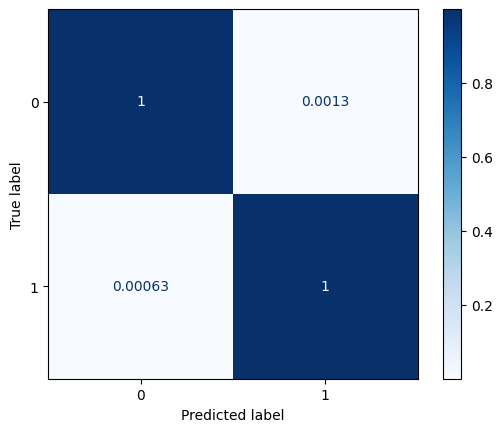

In [ ]:
ConfusionMatrixDisplay.from_estimator(dec_tree, dt_test_preds, y_test, cmap = 'Blues',normalize='true');
print(classification_report(y_test, dt_test_preds));

## building a Logistic Regression Model

In [ ]:
log_reg = LogisticRegression( class_weight='balanced')
# Create a pipeline with preprocessing and the model
logreg_pipe = make_pipeline( col_transformer, log_reg)

# Fit the model
logreg_pipe.fit(X_train, y_train)

# Predictions
logregp_train_preds = logreg_pipe.predict(X_train)
logregp_test_preds = logreg_pipe.predict(X_test)
logreg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                                 ('ordinalFeature',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['High',
                                                                                               'Medium',
                                                                                               'Low',
                                                                                               'Very '
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [ ]:
#evaluation metrics
print_evaluation_metrics('Logistic Regression', y_train, logregp_train_preds, y_test, logregp_test_preds)

Logistic Regression Evaluation Metrics:

Training set Evals:
Accuracy: 0.868
Recall: 0.963
Precision: 0.868


Test set Evals:
Accuracy: 0.864
Recall: 0.963
Precision: 0.862


              precision    recall  f1-score   support

           0       0.87      0.62      0.72      4469
           1       0.86      0.96      0.91     11190

    accuracy                           0.86     15659
   macro avg       0.87      0.79      0.82     15659
weighted avg       0.86      0.86      0.86     15659



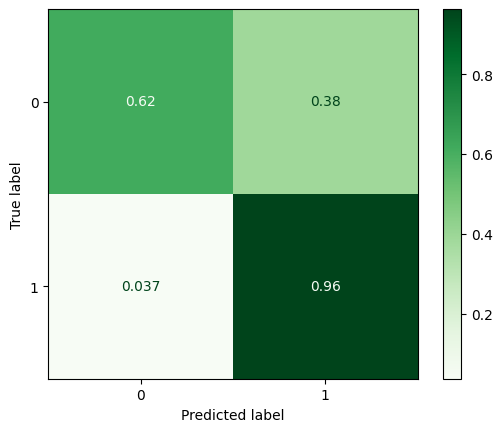

In [ ]:
print(classification_report(y_test, logregp_test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, logregp_test_preds, normalize='true', cmap='Greens');


###looking for the best way to deal with imbalanced classes

In [ ]:
#import imblearn pipeline
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
#Create model pipeline with col transformer, SMOTE, and model
from imblearn.over_sampling import SMOTE
smote = SMOTE()
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote_pipe = make_sampler_pipeline(col_transformer, smote, log_reg_smote)
#Fit and evaluate the model pipeline
log_reg_smote_pipe.fit(X_train, y_train)

log_reg_smote_train_preds = log_reg_smote_pipe.predict(X_train)
log_reg_smote_test_preds = log_reg_smote_pipe.predict(X_test)

print_evaluation_metrics('Logistic Regression', y_train, log_reg_smote_train_preds, y_test, log_reg_smote_test_preds)

Logistic Regression Evaluation Metrics:

Training set Evals:
Accuracy: 0.859
Recall: 0.943
Precision: 0.870


Test set Evals:
Accuracy: 0.856
Recall: 0.945
Precision: 0.866


              precision    recall  f1-score   support

           0       0.82      0.63      0.72      4469
           1       0.87      0.95      0.90     11190

    accuracy                           0.86     15659
   macro avg       0.84      0.79      0.81     15659
weighted avg       0.85      0.86      0.85     15659



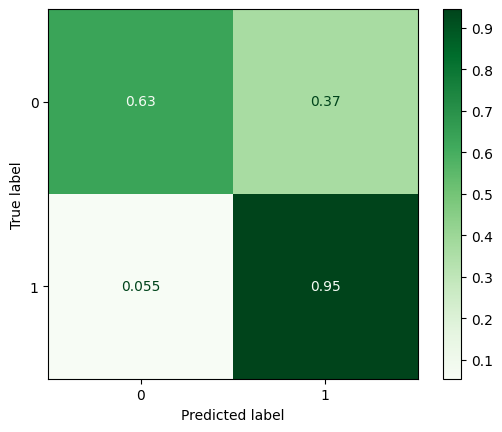

In [ ]:
print(classification_report(y_test, log_reg_smote_test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, log_reg_smote_test_preds, normalize='true', cmap='Greens');

In [ ]:
#import imblearn pipeline
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.under_sampling import RandomUnderSampler
#Import RandomOverSampling
from imblearn.over_sampling import RandomOverSampler
#Create an oversampling pipeline
over_sampler = RandomOverSampler()
over_sample_pipe = make_sampler_pipeline(col_transformer, over_sampler)
#Scale and oversample the data.
X_train_over, y_train_over = over_sample_pipe.fit_resample(X_train, y_train)
#Create the oversampling modeling pipeline
log_reg_over = LogisticRegression(max_iter=1000)
over_sample_log_reg_pipe = make_sampler_pipeline(col_transformer, over_sampler, log_reg_over)
#Fit and evaluate the model
over_sample_log_reg_pipe.fit(X_train, y_train)


log_reg_over_sample_train_preds = over_sample_log_reg_pipe.predict(X_train)
log_reg_over_sample_test_preds = over_sample_log_reg_pipe.predict(X_test)

print_evaluation_metrics('Logistic Regression', y_train, log_reg_over_sample_train_preds, y_test, log_reg_over_sample_test_preds)

Logistic Regression Evaluation Metrics:

Training set Evals:
Accuracy: 0.871
Recall: 0.968
Precision: 0.867


Test set Evals:
Accuracy: 0.866
Recall: 0.968
Precision: 0.862


              precision    recall  f1-score   support

           0       0.89      0.61      0.72      4469
           1       0.86      0.97      0.91     11190

    accuracy                           0.87     15659
   macro avg       0.87      0.79      0.82     15659
weighted avg       0.87      0.87      0.86     15659



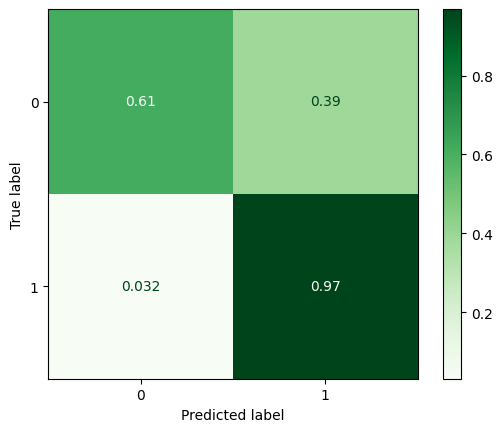

In [ ]:
print(classification_report(y_test, log_reg_over_sample_test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, log_reg_over_sample_test_preds, normalize='true', cmap='Greens');

###Logistic Regression Model Tuning

In [ ]:
log_reg.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Define the parameter grid for GridSearchCV
logreg_pipe_param_grid = {
    'logisticregression__C': [0.0001,0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['lbfgs', 'liblinear'],

}

# Use GridSearchCV for hyperparameter tuning
logreg_pipe_grid = GridSearchCV(logreg_pipe, logreg_pipe_param_grid, cv=5)
logreg_pipe_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dt...
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('logisticregression',
                                        LogisticRegression(class_weight='balanced'))]),
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['lbfgs', 'liblinear']})

In [ ]:
logreg_pipe_grid.best_params_

{'logisticregression__C': 0.0001,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'liblinear'}

In [ ]:
#retrieve the best version of the model
logreg_best_model = logreg_pipe_grid.best_estimator_

#refit the model on the whole training set
logreg_best_model.fit(X_train, y_train)
# prediction
logreg_best_model_train_pred = logreg_best_model.predict(X_train)
logreg_best_model_test_pred = logreg_best_model.predict(X_test)

#score the model on the test set
logreg_best_model.score(X_test, y_test)

0.8759818634651

In [ ]:
#evaluation metrics
print_evaluation_metrics('Logistic Regression Tuned', y_train, logreg_best_model_train_pred, y_test, logreg_best_model_test_pred)

Logistic Regression Tuned Evaluation Metrics:

Training set Evals:
Accuracy: 0.882
Recall: 0.975
Precision: 0.874


Test set Evals:
Accuracy: 0.876
Recall: 0.975
Precision: 0.868


              precision    recall  f1-score   support

           0       0.91      0.63      0.74      4469
           1       0.87      0.97      0.92     11190

    accuracy                           0.88     15659
   macro avg       0.89      0.80      0.83     15659
weighted avg       0.88      0.88      0.87     15659



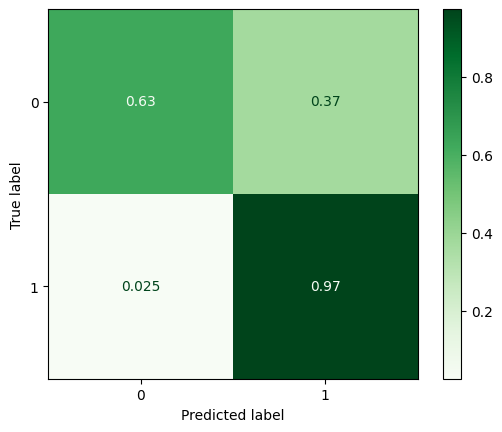

In [ ]:
print(classification_report(y_test, logreg_best_model_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test, logreg_best_model_test_pred, normalize='true', cmap='Greens');

## building a kneighborsclassifier Model

In [ ]:
knn = KNeighborsClassifier( n_neighbors=1, weights='distance')
# Create a pipeline with preprocessing and the model
knn_pipe = make_pipeline( col_transformer, knn)

# Fit the model
knn_pipe.fit(X_train, y_train)

# Predictions
knn_train_preds = knn_pipe.predict(X_train)
knn_test_preds = knn_pipe.predict(X_test)
knn_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dtype='object')),
                                                 ('ordinalFeature',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['High',
                                                                                               'Medium',
                                                                                               'Low',
                                                                                               'Very '
                                                                                               'Low'],
                                                                                              ['High',
                                                                                               'Medium',
                                                                                               'Low']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=1, weights='distance'))])

In [ ]:
#evaluation metrics
print_evaluation_metrics('KNN', y_train, knn_train_preds, y_test, knn_test_preds)

KNN Evaluation Metrics:

Training set Evals:
Accuracy: 1.000
Recall: 1.000
Precision: 1.000


Test set Evals:
Accuracy: 0.895
Recall: 0.939
Precision: 0.917


              precision    recall  f1-score   support

           0       0.84      0.79      0.81      4469
           1       0.92      0.94      0.93     11190

    accuracy                           0.90     15659
   macro avg       0.88      0.86      0.87     15659
weighted avg       0.89      0.90      0.89     15659



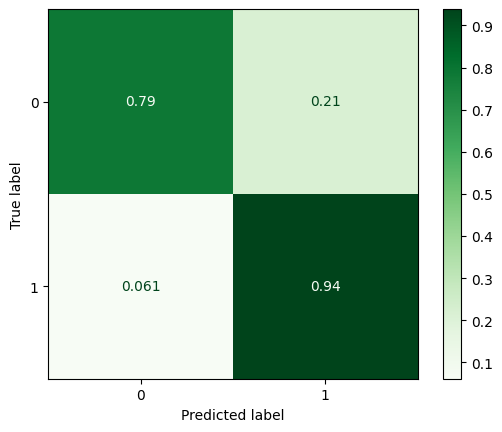

In [ ]:
print(classification_report(y_test, knn_test_preds))
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_preds, normalize='true', cmap='Greens');

### kneighborsclassifier Model Tuning

In [ ]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'distance'}

In [ ]:
# Define the parameter grid for GridSearchCV
knn_pipe_param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 6, 7, 8, 10],
    'kneighborsclassifier__metric': ['minkowski','euclidean','manhattan']
}

# Use GridSearchCV for hyperparameter tuning
knn_pipe_grid = GridSearchCV(knn_pipe, knn_pipe_param_grid, cv=5)
knn_pipe_grid.fit(X_train, y_train)

# Use GridSearchCV for hyperparameter tuning
knn_pipe_grid = GridSearchCV(knn_pipe, knn_pipe_param_grid, cv=5)
knn_pipe_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['UTC', 'Temperature[C]', 'Humidity[%]', 'eCO2[ppm]', 'Raw H2', 'PM1.0',
       'PM2.5', 'NC0.5', 'NC1.0', 'NC2.5', 'CNT'],
      dt...
                                                                                                                      'Low']])),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Raw Ethanol', 'Pressure[hPa]'], dtype='object'))],
                                                          verbose_feature_names_out=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=1,
                                                             weights='distance'))]),
             param_grid={'kneighborsclassifier__metric': ['minkowski',
                                                          'euclidean',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 6, 7, 8,
                                                               10]})

In [ ]:
knn_pipe_grid.best_params_

{'kneighborsclassifier__metric': 'manhattan',
 'kneighborsclassifier__n_neighbors': 6}

In [ ]:
#retrieve the best version of the model
knn_best_model = knn_pipe_grid.best_estimator_

#refit the model on the whole training set
knn_best_model.fit(X_train, y_train)
# prediction
knn_best_model_train_pred = knn_best_model.predict(X_train)
knn_best_model_test_pred = knn_best_model.predict(X_test)

#score the model on the test set
knn_best_model.score(X_test, y_test)

0.9210677565617217

In [ ]:
#evaluation metrics
print_evaluation_metrics('KNN tuned', y_train, knn_best_model_train_pred, y_test, knn_best_model_test_pred)

KNN tuned Evaluation Metrics:

Training set Evals:
Accuracy: 1.000
Recall: 1.000
Precision: 1.000


Test set Evals:
Accuracy: 0.921
Recall: 0.977
Precision: 0.918


              precision    recall  f1-score   support

           0       0.93      0.78      0.85      4469
           1       0.92      0.98      0.95     11190

    accuracy                           0.92     15659
   macro avg       0.92      0.88      0.90     15659
weighted avg       0.92      0.92      0.92     15659



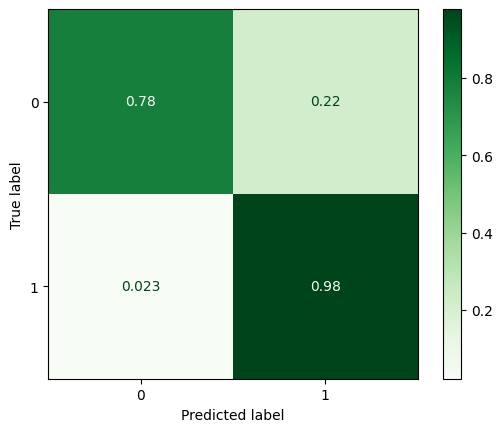

In [ ]:
print(classification_report(y_test, knn_best_model_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test, knn_best_model_test_pred, normalize='true', cmap='Greens');



##Final model selection

- What do 'false positives' and 'false negatives' mean for this problem? Which is worse?

  - 'false positives'= there is no fire but the alarm is ON.
  - 'false negatives'= There is fire but the alarm is Off.

the false negatives are definitely worse because they are a main source of risk.

- Which of your models would you recommend for production? Which metric or metrics did you use to decide that, and why?

   - (decision tree is the best model because i have ..)

   - Tuned k-nearest neighbors Model is the recommended model for fire detection:
     - it is accurancy (0.92) is better than the one of Tuned Logistic Regression (0.87)
    - metrics recall and precision are important in this case. A higher recall means fewer false negative predictions, also known as type 2 errors, which mean a lower risk that the alarm is off when actualy there is a fire and a high precision means fewer type 1 errors, or fewer false positives, which mean a lower risk to turn on the alarm while there is no fire.

    - in the Tuned k-nearest neighbors Model, testing recall is 0.977 and testing precision is 0.918, which is a better result than the one obtained from the other model(Vs recall=0.975 and precision=0.868 for tuned logistic regression).